In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, warnings
from mpl_toolkits.basemap import Basemap
plt.style.use('fivethirtyeight')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
warnings.filterwarnings('ignore')

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
file_list = check_output(["ls", "../input"]).decode("utf8")
file_list = file_list.strip().split('\n')

air_reserve.csv
air_store_info.csv
air_visit_data.csv
date_info.csv
hpg_reserve.csv
hpg_store_info.csv
sample_submission.csv
store_id_relation.csv



# Read data and display info

In [3]:
for index, file in enumerate(file_list):
    var_name = file.rstrip('.csv')
    locals()[var_name] = pd.read_csv('../input/' + file)
    print(file)
    
    # convert to datetime
    for col in locals()[var_name].columns:
        if col.endswith('datetime') or col.endswith('date'):
            locals()[var_name][col] = pd.to_datetime(locals()[var_name][col])
    
    print('Shape:', locals()[var_name].shape)
    print('\n')
    print(locals()[var_name].info())
    print('\n')
    print(locals()[var_name].head())
    print('\n')

air_reserve.csv
Shape: (92378, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB
None


           air_store_id      visit_datetime    reserve_datetime  \
0  air_877f79706adbfb06 2016-01-01 19:00:00 2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
3  air_877f79706adbfb06 2016-01-01 20:00:00 2016-01-01 16:00:00   
4  air_db80363d35f10926 2016-01-01 20:00:00 2016-01-01 01:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 6  
3                 2  
4                 5  


air_store_info.csv
Shape: (829, 5)


<class 'pandas.core.fra

# Store Distribution map

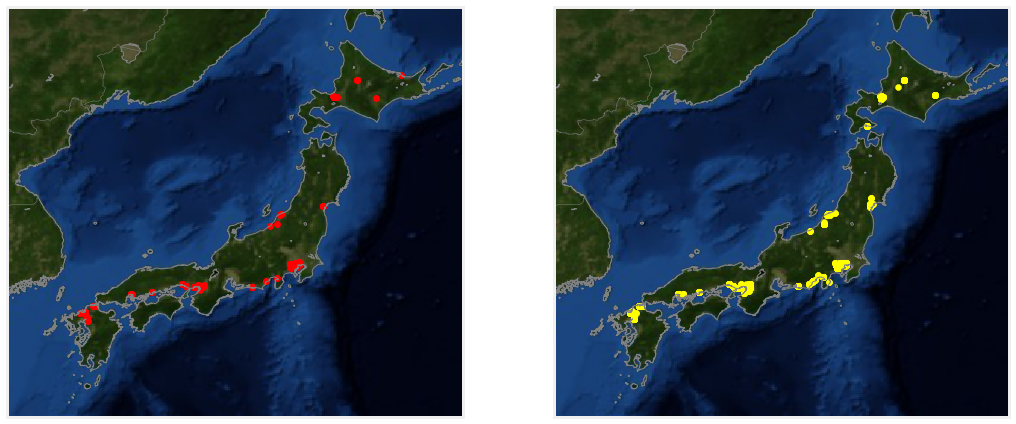

In [4]:
fig,ax = plt.subplots(1,2,figsize = (16,16))

color = ['red','yellow']
for i,data in enumerate([air_store_info,hpg_store_info]):
    m = Basemap(resolution = 'h',lon_0 = 0, lat_0 = 0,llcrnrlon=127, urcrnrlon=147,
                      llcrnrlat=29, urcrnrlat=47, ax = ax[i])
    m.bluemarble()
    m.drawcoastlines(color = 'gray')
    m.drawcountries(color = 'gray')
    m.drawstates(color = 'gray')
    m.scatter(data['longitude'], data['latitude'], latlon = True, color = color[i], marker='o')

# Visitors visualization

Aggregated vistors by visit date

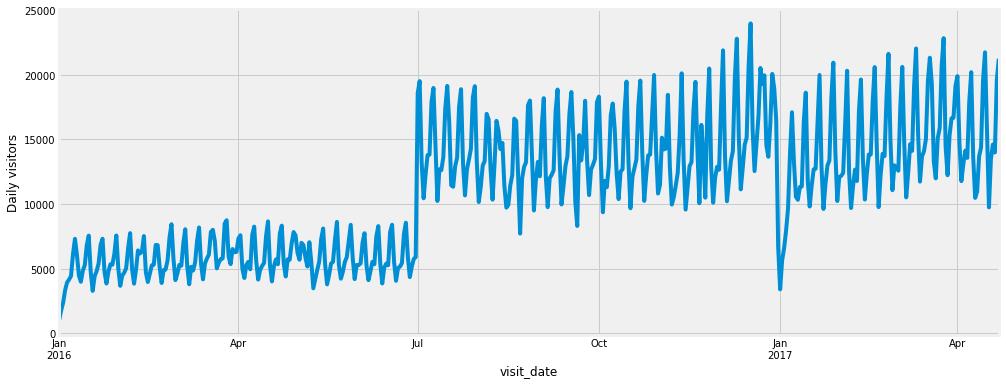

In [66]:
air_visit_data.groupby('visit_date')['visitors'].sum().resample('D').sum().plot()
plt.ylabel('Daily visitors')

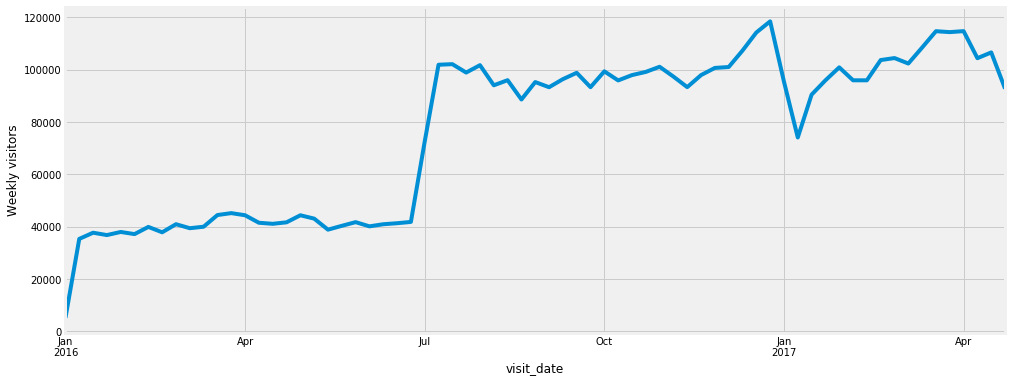

In [67]:
air_visit_data.groupby('visit_date')['visitors'].sum().resample('W').sum().plot()
plt.ylabel('Weekly visitors')

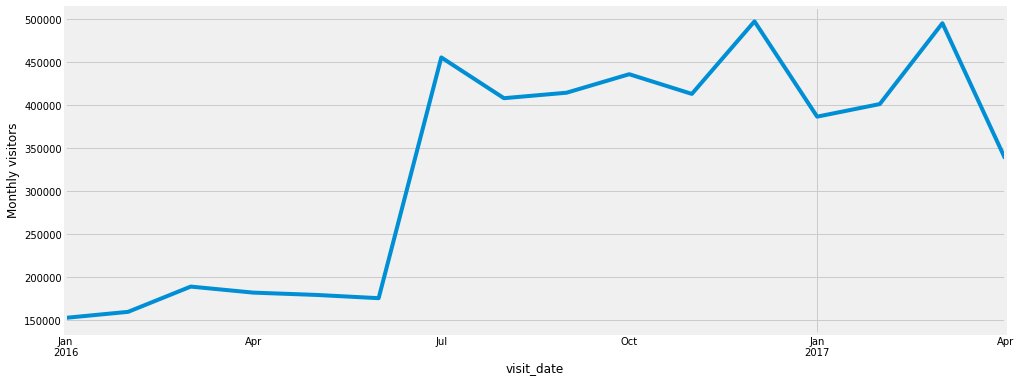

In [68]:
air_visit_data.groupby('visit_date')['visitors'].sum().resample('M').sum().plot()
plt.ylabel('Monthly visitors')

Let's get deeper into air_reserve dataset.

In [20]:
air_store = air_reserve.merge(air_store_info, how = 'inner', on = 'air_store_id').drop(['latitude','longitude'], axis = 1)
air_store.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen


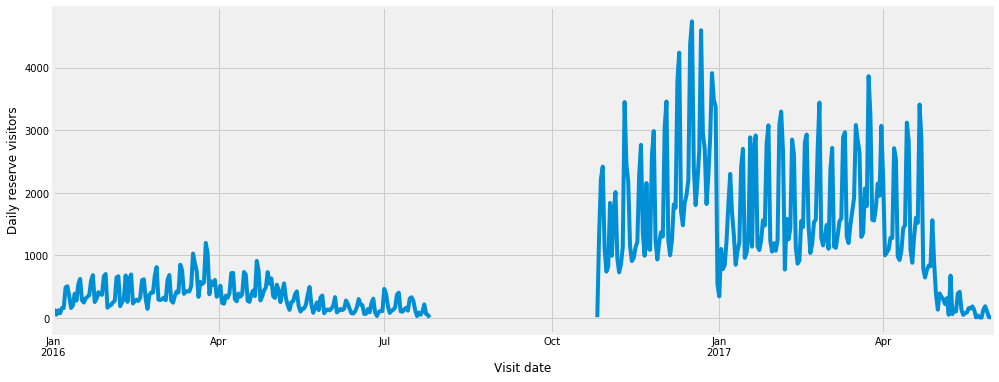

In [79]:
air_reserve.groupby('visit_datetime')['reserve_visitors'].sum().resample('D').sum().plot()
plt.xlabel('Visit date')
plt.ylabel('Daily reserve visitors')

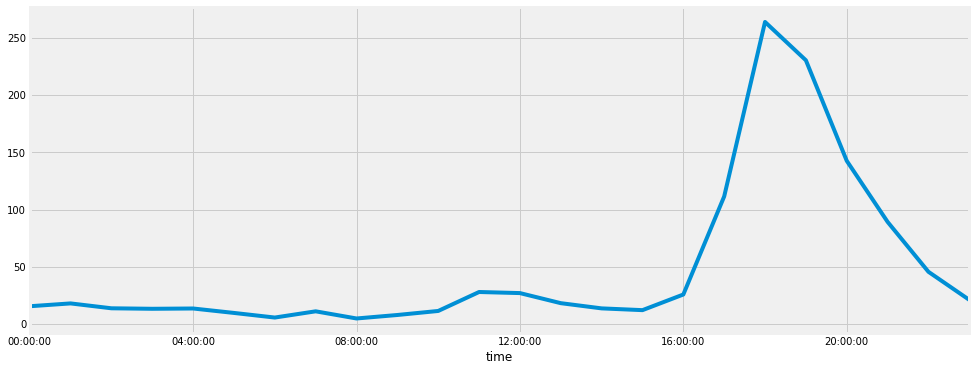

In [74]:
data = air_reserve.groupby('visit_datetime')['reserve_visitors'].sum()
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks);

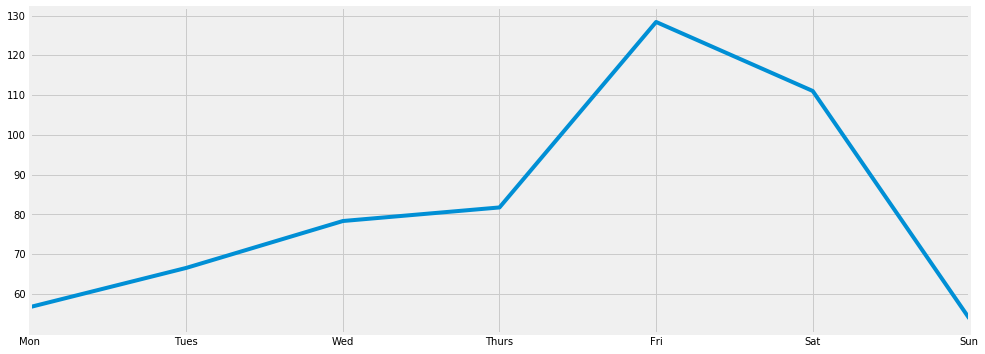

In [77]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot();

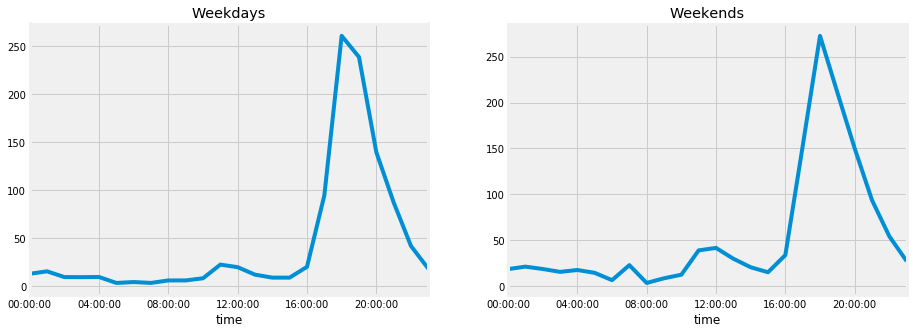

In [82]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks)
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks);

What are the distribution of time period between reserve and visit?

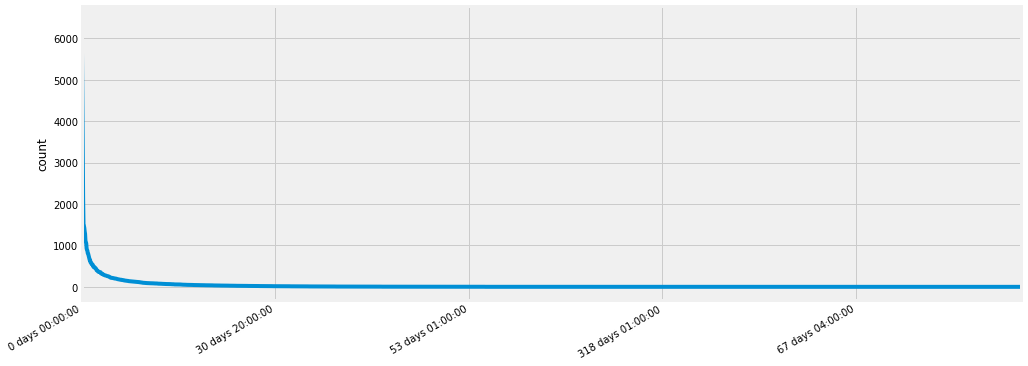

In [31]:
air_store['delta_reservation'] = air_store['visit_datetime'] - air_store['reserve_datetime']
air_store['delta_reservation'].value_counts().plot()
plt.ylabel('count')

How many visitors for each time period?

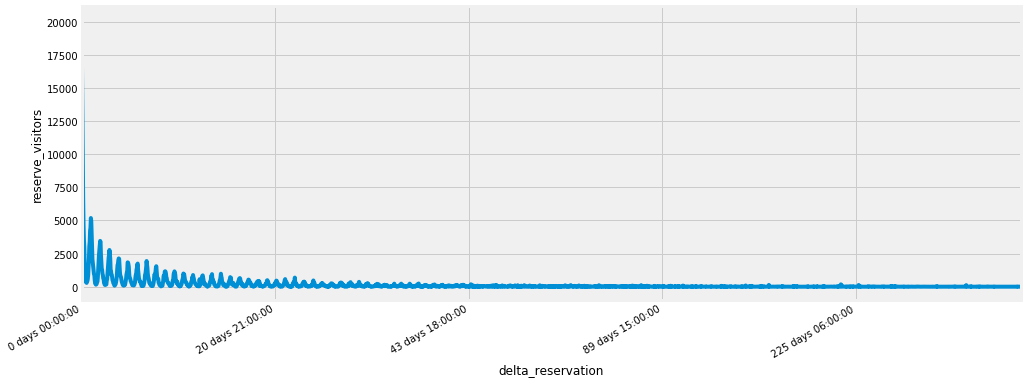

In [35]:
air_store.groupby('delta_reservation')['reserve_visitors'].sum().plot()
plt.ylabel('reserve_visitors')

What are the distribution of air_genre_name and air_area_name?

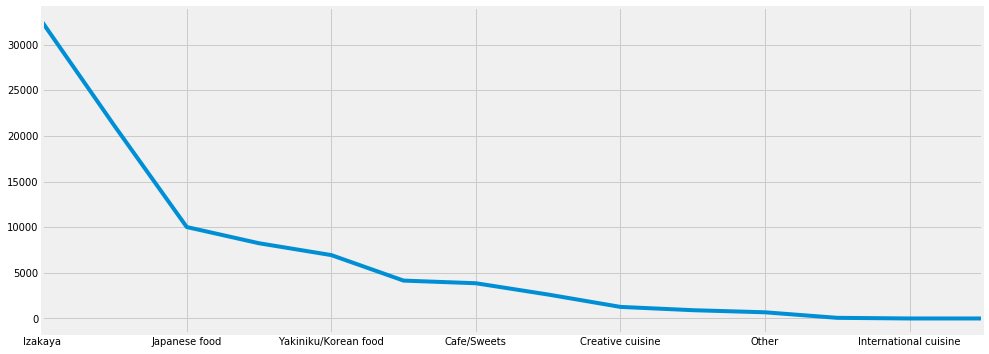

In [45]:
air_store['air_genre_name'].value_counts().plot()

What is the holiday influence?

In [48]:
date_info = date_info.rename(columns = {'calendar_date':'visit_date'})
air_holiday = air_visit_data.merge(date_info, how = 'inner', on = 'visit_date')
air_holiday.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,21,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,40,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,5,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,18,Wednesday,0


In [59]:
air_holiday.groupby('holiday_flg')['visitors'].mean()

holiday_flg
0    22.931937
1    16.444444
Name: visitors, dtype: float64

Seems holiday has even a negative influence.